# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


from IPython.core.display  import HTML
from matplotlib            import pyplot as plt
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model  import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [2]:
def jupyter_settings():
        %matplotlib inline
        
        plt.style.use('bmh')
        plt.rcParams['figure.figsize'] = [25 , 12]
        plt.rcParams['font.size'] = 24
        
        display( HTML( '<style>.container { width:100% !important; }</style>') )
        pd.options.display.max_columns = None
        pd.options.display.max_rows = None
        pd.set_option( 'display.expand_frame_repr', False )
        
        sns.set()

In [3]:
jupyter_settings()

# 0.1 Load Dataset

In [4]:
df = pd.read_excel('time_series_data.xlsx')

In [5]:
df.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.13,20210420
1,A0,25082,UN,14.13,20210420
2,A0,25430,UN,14.13,20210922
3,A0,25463,UN,12.84,20210209
4,A0,25800,UN,12.84,20210209


# 1.0 Data Description

## 1.1 Data Dimension

In [6]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 4460
Number of columns: 5


## 1.2 Check NA

In [7]:
df.isna().sum()

produto_descricao                         0
produto_quantidade                        0
produto_unidade_comercial                 0
produto_valor_unitario_comercializacao    0
nota_data_emissao                         0
dtype: int64

## 1.3 Data Types

In [8]:
df.dtypes

produto_descricao                          object
produto_quantidade                          int64
produto_unidade_comercial                  object
produto_valor_unitario_comercializacao    float64
nota_data_emissao                           int64
dtype: object

## 1.4 Convert to Datetime

In [9]:
df['nota_data_emissao'] = pd.to_datetime(df['nota_data_emissao'], format='%Y%m%d')

In [10]:
df.describe()

,produto_quantidade,produto_valor_unitario_comercializacao
count,4460.000000,4460.000000
mean,424.202242,20.508176
std,2036.972760,44.426198
min,0.000000,0.620000
25%,45.000000,8.380000
50%,72.000000,11.420000
75%,183.000000,27.200000
max,42000.000000,1812.390400


# 2.0 Data Preparation

In [11]:
#df = df.groupby(['nota_data_emissao', 'produto_descricao']).agg({'produto_unidade_comercial': 'first',
#                                          'produto_valor_unitario_comercializacao': 'first', 'produto_quantidade': 'sum'}).reset_index()

In [12]:
rs = StandardScaler()

In [13]:
rs.fit(df[['produto_quantidade']])

StandardScaler()

In [14]:
#df['produto_quantidade'] = rs.transform(df[['produto_quantidade']])

In [15]:
df_final = df.copy()

In [16]:
df['produto_quantidade'] = np.log1p(df['produto_quantidade'])

df['produto_valor_unitario_comercializacao'] = rs.transform(df[['produto_valor_unitario_comercializacao']])

C:\Users\kaka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- produto_valor_unitario_comercializacao
Feature names seen at fit time, yet now missing:
- produto_quantidade

  warnings.warn(message, FutureWarning)


In [17]:
df['ano'] = pd.DatetimeIndex(df['nota_data_emissao']).year
df['mes'] = pd.DatetimeIndex(df['nota_data_emissao']).month
df['dia'] = pd.DatetimeIndex(df['nota_data_emissao']).day

In [18]:
#month
df['mes_sin'] = df['mes'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df['mes_cos'] = df['mes'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

#day
df['dia_sin'] = df['dia'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df['dia_cos'] = df['dia'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

In [19]:
le = LabelEncoder()

In [20]:
le.fit(df['produto_descricao'])
df['produto_descricao'] = le.transform(df['produto_descricao'])

le.fit(df['produto_unidade_comercial'])
df['produto_unidade_comercial'] = le.transform(df['produto_unidade_comercial'])


le.fit(df['ano'])
df['ano'] = le.transform(df['ano'])

# 3.0 Machine Learnind Model

In [21]:
#training dataset
X_train = df[df['nota_data_emissao'] < '2021-08-03']
y_train = X_train['produto_quantidade']

#test dataset
X_test = df[df['nota_data_emissao'] >= '2021-08-03']
y_test = X_test['produto_quantidade']

print( 'Training Min Date: {}'.format(X_train['nota_data_emissao'].min()))
print( 'Training Max Date: {}'.format(X_train['nota_data_emissao'].max()))

print( '\nTest Min Date: {}'.format(X_test['nota_data_emissao'].min()))
print( 'Test Max Date: {}'.format(X_test['nota_data_emissao'].max()))

Training Min Date: 2020-10-01 00:00:00
Training Max Date: 2021-08-02 00:00:00

Test Min Date: 2021-08-04 00:00:00
Test Max Date: 2021-09-30 00:00:00


In [22]:
X_train = X_train.drop(['dia', 'mes', 'nota_data_emissao', 'produto_quantidade'], axis=1)
X_test = X_test.drop(['dia', 'mes', 'nota_data_emissao', 'produto_quantidade'], axis=1)

In [23]:
#model 
lr =  LinearRegression().fit(X_train, y_train)

#prediction
yhat_lr = lr.predict(X_test)

#perfomance
#lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
#lr_result

In [26]:
mean_squared_error(np.expm1(y_test), np.expm1(yhat_lr), squared=False)

2560.242151059153

In [27]:
mean_absolute_percentage_error(np.expm1(y_test), np.expm1(yhat_lr))

2.6151944038875365

In [33]:
df_final = df_final[df_final['nota_data_emissao'] >= '2021-08-03']

In [34]:
df_final['predict'] = np.expm1(yhat_lr)

<AxesSubplot: xlabel='nota_data_emissao', ylabel='produto_quantidade'>

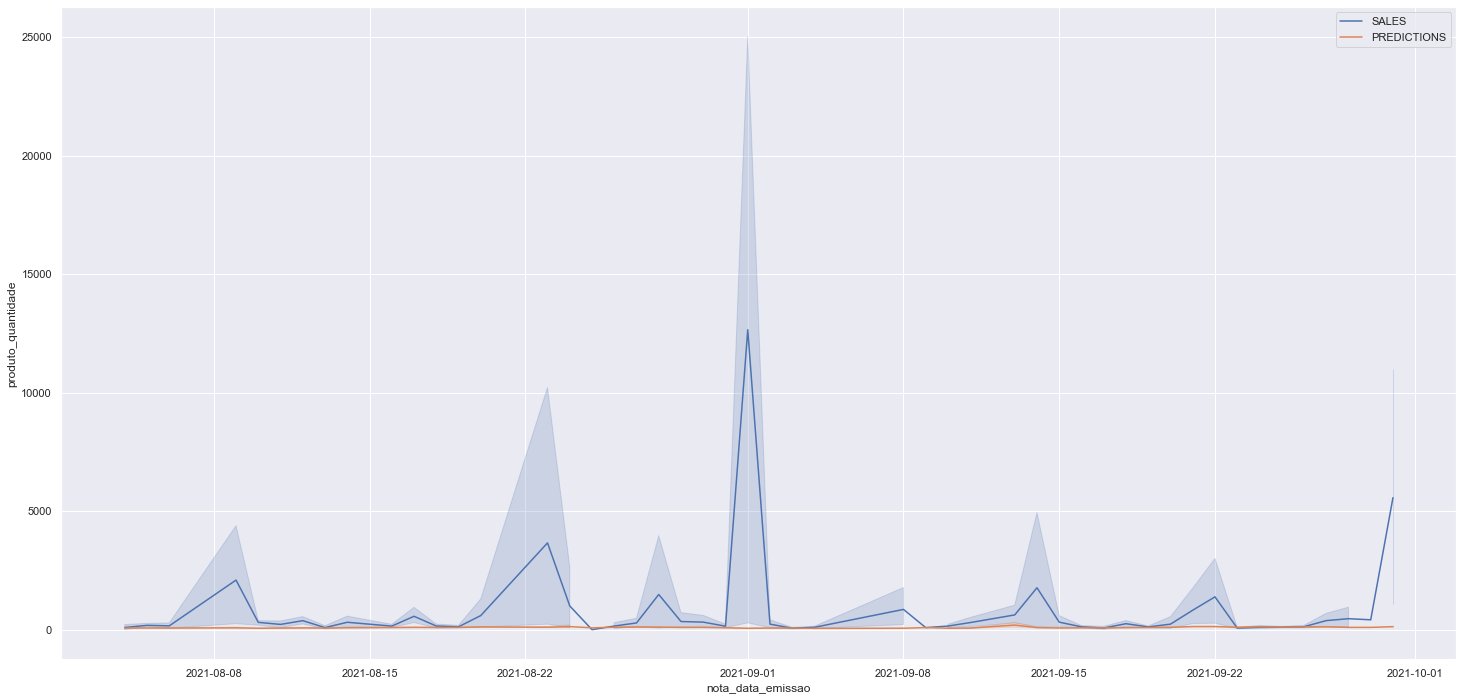

In [35]:
sns.lineplot(x='nota_data_emissao', y='produto_quantidade', data=df_final, label='SALES')
sns.lineplot(x='nota_data_emissao', y='predict', data=df_final, label='PREDICTIONS')

In [36]:
df_final.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao,predict
2,A0,25430,UN,14.1300,2021-09-22,371.902620
7,A0,25963,UN,14.1300,2021-09-30,302.820398
9,A0,26035,UN,14.1300,2021-09-22,371.902620
10,A0,26091,UN,14.1300,2021-09-30,302.820398
27,A7,950,KG,101.0083,2021-09-13,658.685983
